#  Markowitz vs Signature trading (order 0)

Setup : 

One of the most interesting examples to analyze is undoubtedly the optimal portfolio model according to Markowitz. 

The advantage is that we know the optimal weights to allocate to each asset in this static optimization problem through a closed-form solution.

Suppose our asset portfolio $X$ is such that : $ \log(X) \sim \mathcal{N}(\mu, \Sigma) $.

The optimal weights to allocate to each component of the portfolio are given by: $ w_{Markowitz} = \frac{\Sigma^{-1}\mu}{2\lambda} $ where $\lambda$ corresponds to the inverse proportional of $\sqrt{\Delta} $.

In the context of our signature trading, the functionals $\ell = (\ell_{1}, \ldots, \ell_{m})$ theoretically correspond to these weights. With: $ \ell_{m} = \langle \ell_m, 1 \rangle  = \langle \ell_m, \hat{\mathbb{Z}}^{\leq 0}_{0,t} \rangle = \xi_{t}^{m} $.

Our goal is to see to what extent our signature trader is capable of learning the underlying signals in the sense of Markowitz.

The mean $\mu$ is generated arbitrarily following a uniform distribution, and the covariance matrix $\Sigma$ is simulated according  to a Hankel matrix.



### Some useful

In [1]:
import strat
import torch
import useful
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

plt.style.use('ggplot') 
plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['lines.linewidth'] = 2.5 

seed=2024
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### 1. Get data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


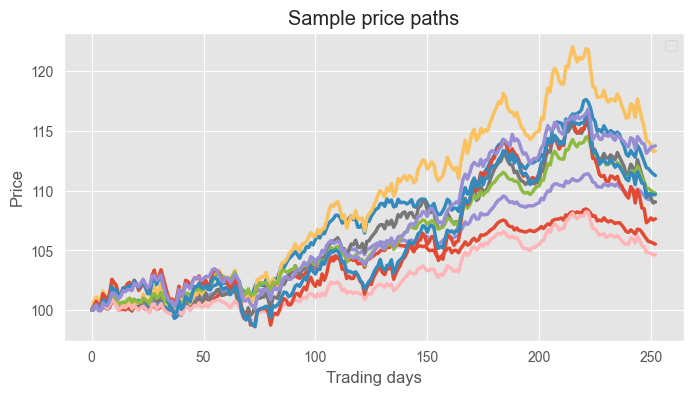

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

d=10 # number of assets
n_trading_days=252 # number of trading days
N_years = 1 # if = a , evaluation will be on n_trading_days*a
mu_mean=0.05
sigma_mean=-0.075
t0_price=100
batch_len=1000
simulator = strat.Get_data_Markowitz(d=d, n_trading_days=n_trading_days, N_years=N_years,
                                   mu_mean=mu_mean, sigma_mean=sigma_mean,
                                   t0_price=t0_price,batch_len=batch_len)

batch_prices = simulator.simulate(batch_len=batch_len)[0]
returns_subset = simulator.simulate(batch_len=batch_len)[1]


index = random.randint(0, batch_len) # for plot
R_t = returns_subset[index] # sample of returns
X_t_m_indexed = batch_prices[index] # sample of prices


plt.plot(X_t_m_indexed)
plt.legend()
plt.title("Sample price paths")
plt.xlabel("Trading"+" "+"days")
plt.ylabel("Price")

workspace='C:/Users/alpho/Desktop/R&D/2-en cours/SIGNATORY/Projet_signature_trading_Alphonse'

plt.savefig(workspace+'/img/Mkwtz_prices_paths.pdf', format='pdf')
plt.show()

### 2. Markowitz

In [3]:
################# 
# params
#################

mu=simulator.param()[0]
Sigma=simulator.param()[1]

rate=simulator.param()[2]
N=simulator.param()[3]
batch_len=simulator.param()[4]

####################

# Weigts computing and standardization (to see them as proportions of all weights)

w_markowitz= torch.inverse(Sigma) @ mu
w_markowitz /= torch.sum(w_markowitz) 


# PnL and Sharpe calculation 

R_t = returns_subset[index]
X_t_m_indexed = batch_prices[index]
exogenous_data = torch.zeros((batch_len, N + 1, 0))
f = exogenous_data[index] 

markowitz_R_t = torch.zeros(N)
markowitz_pnl = torch.zeros(N)

for j in range(N):
    markowitz_R_t[j] = w_markowitz @ R_t[j, :]
    markowitz_pnl[j] = w_markowitz @ (X_t_m_indexed[j, :] * R_t[j, :])

M_value = torch.cumsum(markowitz_pnl, dim=0)
M_daily_R_t_mean , M_daily_return_std = torch.mean(markowitz_R_t),torch.std(markowitz_R_t)

M_SR = M_daily_R_t_mean / M_daily_return_std * np.sqrt(rate)


### 3. Signature trader (troncature order = 0)

In [5]:
# Signature trader fitting
depth = 0
dt = 1 # var(PnL) <= sqrt(delta) (optimization constraint)
Signature_elements = strat.Signature_Trading(depth, dt)
Signature_elements.main_fitting_process(batch_prices, exogenous_data)

mu_sig is ok
sigma_sig is ok
lambda is ok
l_1
Signature level 0:
tensor([0.2017])
l_2
Signature level 0:
tensor([-0.3365])
l_3
Signature level 0:
tensor([1.2434])
l_4
Signature level 0:
tensor([-0.3277])
l_5
Signature level 0:
tensor([-0.0854])
l_6
Signature level 0:
tensor([0.1423])
l_7
Signature level 0:
tensor([-0.0520])
l_8
Signature level 0:
tensor([0.0104])
l_9
Signature level 0:
tensor([-0.0646])
l_10
Signature level 0:
tensor([0.0813])
fitting process is ok


In [6]:
# Signature Trader (ST) PnL and Sharpe

w_sig_trader = torch.tensor([Signature_elements.l[i][0] for i in range(d)])
w_sig_trader /= torch.sum(w_sig_trader) 

ST_return = torch.zeros(N)
ST_pnl = torch.zeros(N)

for i in range(N):
    ST_return[i] = w_sig_trader @ R_t[i, :]
    ST_pnl[i] = w_sig_trader @ (X_t_m_indexed[i, :] * R_t[i, :])

ST_cumulative_PnL = torch.cumsum(ST_pnl, dim=0)
ST_return_mean = torch.mean(ST_return)
ST_return_std = torch.std(ST_return)
ST_sharpe = ST_return_mean / ST_return_std * np.sqrt(rate)

### 4.  Markowitz vs.  Signature Trader Order 0 weights and performance Plot

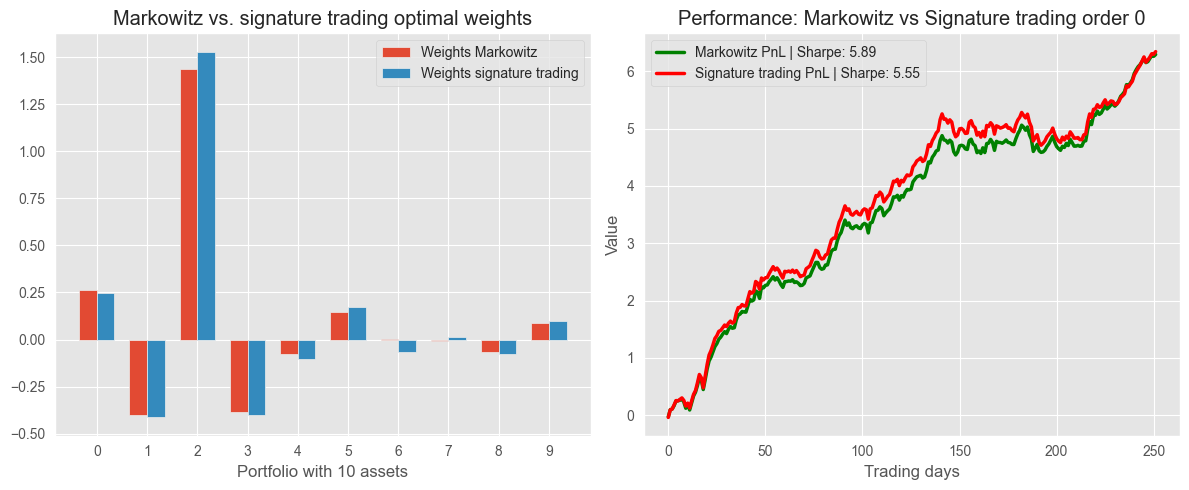

In [7]:
bar_width = 0.35  # width of the bars
index = torch.arange(d)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# weights plot
axes[0].bar(torch.arange(d) - bar_width/2, w_markowitz.flatten(), bar_width, label='Weights Markowitz')
axes[0].bar(torch.arange(d) + bar_width/2, w_sig_trader.flatten(), bar_width, label='Weights signature trading')
axes[0].set_xlabel(f'Portfolio with {d} assets')
axes[0].set_title('Markowitz vs. signature trading optimal weights')
axes[0].set_xticks(torch.arange(d))
axes[0].set_xticklabels(range(d))
axes[0].legend()

# Perf. plot

axes[1].plot(M_value, color='green', label=f'Markowitz PnL | Sharpe: {M_SR:.2f}')
axes[1].plot(ST_cumulative_PnL, color='red', linewidth=2.5, label=f'Signature trading PnL | Sharpe: {ST_sharpe:.2f}')
axes[1].set_xlabel('Trading days')
axes[1].set_ylabel('Value')
axes[1].set_title('Performance: Markowitz vs Signature trading order 0')
axes[1].legend()
axes[1].grid(True)


workspace='C:/Users/alpho/Desktop/R&D/2-en cours/SIGNATORY/Projet_signature_trading_Alphonse'

plt.savefig(workspace+'/img/Mkwtz_vs_sig_trader_perf&w.pdf', format='pdf')

plt.tight_layout()
plt.show()

Weights : 

We can see that our order 0 Signature Trader has almost perfectly learned the optimal Markowitz portfolio weights by observing the dynamics of the price process during the learning phase.

PnL : 

Unsurprisingly, cumulative PnL are also very close.